In [17]:
import pandas as pd
import os
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import torchvision
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import re
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, balance = False):
        self.dataframe = dataframe
        self.transform = transform
        self.root_dir = root_dir
        self.balance = balance

        if self.balance:
            # Balance the dataset by sampling the same number of samples for each class
            self.dataframe = self.balance_dataset()
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, f"{self.dataframe['number'].iloc[idx]}.jpg")
        if os.path.exists(image_path):
            image = Image.open(image_path)
        else:
            image = Image.new('RGB', (224, 224), color='white') # Handle missing image file
        
        classes = torch.tensor(self.dataframe['exp'].iloc[idx], dtype=torch.long)
        label = torch.tensor(self.dataframe.iloc[idx, 2:4].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        
        return image, classes, label
    
    def balance_dataset(self):
        # Group dataframe by the 'exp' column and sample the same number of samples for each class
        balanced_df = self.dataframe.groupby('exp', group_keys=False).apply(lambda x: x.sample(self.dataframe['exp'].value_counts().min()))
        return balanced_df


In [18]:
# Load the annotations for training and validation from separate CSV files
IMAGE_FOLDER = "/data/AffectNet/train_set/images/"
IMAGE_FOLDER_TEST = "/data/AffectNet/val_set/images/"
train_annotations_path = "~/Spielwiese/affectnet/train_set_annotation_without_lnd.csv"
valid_annotations_path = "~/Spielwiese/affectnet/val_set_annotation_without_lnd.csv"
train_annotations_df = pd.read_csv(train_annotations_path)
valid_annotations_df = pd.read_csv(valid_annotations_path)

train_annotations_df = train_annotations_df[train_annotations_df['exp'] != 7] # Remove Contempt
valid_annotations_df = valid_annotations_df[valid_annotations_df['exp'] != 7]

transform_valid =transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_dataset = CustomDataset(dataframe=valid_annotations_df, root_dir=IMAGE_FOLDER_TEST,transform=transform_valid, balance = False)
batch_size = 64
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,num_workers=48)

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL = models.maxvit_t(weights='DEFAULT')
block_channels = MODEL.classifier[3].in_features
MODEL.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(block_channels),
            nn.Linear(block_channels, block_channels),
            nn.Tanh(),
            nn.Linear(block_channels, 9, bias=False),
        )
MODEL.to(DEVICE)
MODEL.load_state_dict(torch.load('best_model_affectnet_improved7VA.pt'))

<All keys matched successfully>

In [23]:
# Set the model to evaluation mode
MODEL.load_state_dict(torch.load('best_model_affectnet_improved7VA.pt'))
MODEL.to(DEVICE)
MODEL.eval()

all_labels_cls = []
all_predicted_cls = []
all_true_values = []
all_predicted_values = []

# Start inference on test set
with torch.no_grad():
    for images, classes, labels in iter(valid_loader):
        images, classes, labels = images.to(DEVICE), classes.to(DEVICE), labels.to(DEVICE)

        outputs = MODEL(images)
        outputs_cls = outputs[:, :7]
        outputs_reg = outputs[:, 7:]

        _, predicted_cls = torch.max(outputs_cls, 1)

        all_labels_cls.extend(classes.cpu().numpy())
        all_predicted_cls.extend(predicted_cls.cpu().numpy())

        # Append to the lists --> Regression
        true_values = labels.cpu().numpy()
        predicted_values = outputs_reg.cpu().numpy()
        all_true_values.extend(true_values)
        all_predicted_values.extend(predicted_values)

accuracy_cls = (np.array(all_labels_cls) == np.array(all_predicted_cls)).mean()
print(f'Test Accuracy on Classification: {accuracy_cls * 100:.2f}%')

# Print accuracy per class using the label_mapping and map labels
label_mapping = {
    'Neutral': 0,
    'Happy': 1,
    'Sad': 2,
    'Suprise': 3,
    'Fear': 4,
    'Disgust': 5,
    'Anger': 6,
    #'Contempt' :7,
}
class_names = ['Neutral', 'Happy', 'Sad', 'Suprise', 'Fear', 'Disgust', 'Anger']
mapped_labels = [label_mapping[name] for name in class_names]

# Get a classification report 
classification_rep = classification_report(all_labels_cls, all_predicted_cls, labels=mapped_labels, target_names=class_names, zero_division=0.0)
print("Classification Report:\n", classification_rep)

Test Accuracy on Classification: 66.60%
Classification Report:
               precision    recall  f1-score   support

     Neutral       0.60      0.61      0.60       500
       Happy       0.81      0.86      0.83       500
         Sad       0.69      0.66      0.67       500
     Suprise       0.59      0.67      0.63       500
        Fear       0.68      0.66      0.67       500
     Disgust       0.68      0.60      0.64       500
       Anger       0.62      0.60      0.61       500

    accuracy                           0.67      3500
   macro avg       0.67      0.67      0.67      3500
weighted avg       0.67      0.67      0.67      3500



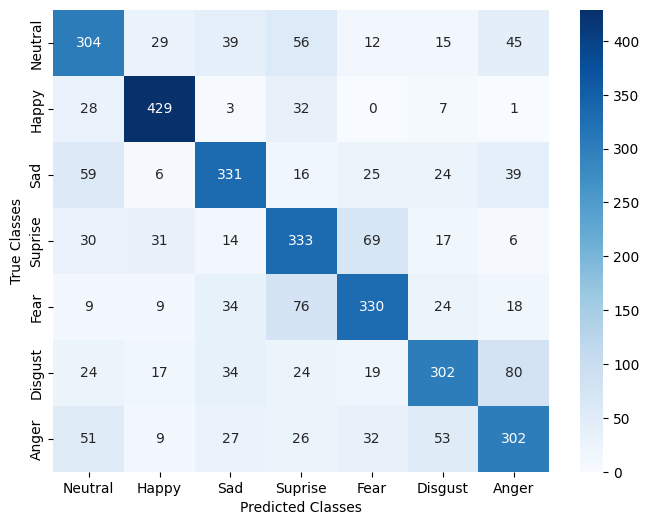

In [24]:
# ***** Print the classification confusion matrix *****

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels_cls, all_predicted_cls)

# Plot confusion matrix as heatmap
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.show()

plot_confusion_matrix(all_labels_cls, all_predicted_cls, classes=class_names)